In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'ENPM809K/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM809K/assignment1/cs231n/datasets
/content/drive/My Drive/ENPM809K/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [1e-3, 1e-5, 1e-7, 1e-9]
regularization_strengths = [2e-1, 3e-1, 5e-1, 6e-1]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for eachLR in learning_rates:
  for eachRegStr in regularization_strengths:
    print(" <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> ")
    print('lr %e reg %e' % (eachLR, eachRegStr))
    
    # Training the LinearSVM classifier with each regularization strength for
    # every learning rate. Final 1500 iterations using the training data
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=eachLR, reg=eachRegStr,
                      num_iters=2000, verbose=False)
    
    # Calculating the accuracy on training and validation data to evaluate the 
    # performance
    y_train_pred = svm.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('training accuracy: %f validation accuracy: %f' % (train_accuracy, val_accuracy))

    # Storing the training and validation accuracy results in the results dict
    results[(eachLR,eachRegStr)] = (train_accuracy,val_accuracy)

    # Check for the best validation accuracy and the best object which gives it
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_svm = svm
    
print("\n")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-03 reg 2.000000e-01
training accuracy: 0.502939 validation accuracy: 0.493000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-03 reg 3.000000e-01
training accuracy: 0.501755 validation accuracy: 0.494000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-03 reg 5.000000e-01
training accuracy: 0.498490 validation accuracy: 0.486000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-03 reg 6.000000e-01
training accuracy: 0.498898 validation accuracy: 0.481000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-05 reg 2.000000e-01
training accuracy: 0.415245 validation accuracy: 0.420000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-05 reg 3.000000e-01
training accuracy: 0.410898 validation accuracy: 0.412000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-

In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.48


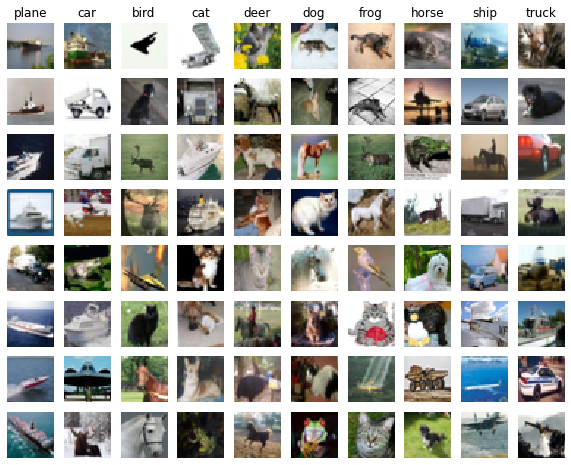

In [22]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

Yes. 

*   The classification results are definitely better off the ones we obtained when we trained SVM on raw pixels.

*   Since the classification is based on image features and color histogram, we see the misclassification results very close feature-wise. For example, the dog classification results at least contain animals like cats, horses or frogs which could be because these classes have some features in common like legs and overall appearance. Similarly the deer, birds and horses are classified as one for all the same reasons. The classifier no longer significantly classifies because of just the backgrounds of images (which was the case before).

*   We can also see that the classifier faces the challenges we talked about in class such as Intra-class variation, rotation or viewpoint variation. For example, we can see a brown and a white horse classified as a dog and as a frog respectively even if their positions are similar. On the same lines a brown and white horse (again) are classified in the bird class even when they are facing in opposite directions.






## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [23]:
from cs231n.data_utils import get_CIFAR10_data
data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

# Aligning data dict according to the feature space
data['X_train'] = X_train_feats
data['y_train'] = y_train
data['X_val'] = X_val_feats
data['y_val'] = y_val
data['X_test'] = X_test_feats
data['y_test'] = y_test
print("\n")
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


('X_train: ', (49000, 154))
('y_train: ', (49000,))
('X_val: ', (1000, 154))
('y_val: ', (1000,))
('X_test: ', (1000, 154))
('y_test: ', (1000,))


In [19]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
best_model = None
results = {}

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Similar to the two_layer_net we train the NN here
learning_rates = [1e-1, 2e-1, 3e-1]
regularization_strengths = [1e-5, 1e-6, 1e-7]
epochs = [10, 20]
hidden_layer_sizes = [300, 500, 600]


for eachLR in learning_rates:
  for eachRegStr in regularization_strengths:
    for eachHidden in hidden_layer_sizes:
      for eachEpoch in epochs:

        model = TwoLayerNet(input_dim, hidden_dim=eachHidden, num_classes=10)
        net = Solver(model, data, update_rule='sgd', optim_config={
                        'learning_rate':eachLR}, lr_decay=0.95, num_epochs=eachEpoch,
                        batch_size=200, print_every=-1, verbose=False)
        net.train()

        # Find the best val_accuracy
        val_accuracy = net.best_val_acc
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_net = net
            best_model = model
        
        print(" <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> ")
        print('lr %e reg %e hidden %d val accuracy: %f' % (eachLR, eachRegStr, 
                                                      eachHidden, val_accuracy))
      
print('best validation accuracy achieved during cross-validation: %f' % best_val)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 300 val accuracy: 0.561000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 300 val accuracy: 0.598000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 500 val accuracy: 0.566000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 500 val accuracy: 0.607000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 600 val accuracy: 0.566000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-05 hidden 600 val accuracy: 0.594000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.000000e-06 hidden 300 val accuracy: 0.561000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-01 reg 1.00000

In [21]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.582
